# Neural Style Transfer Using Pythorch

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

from PIL import Image
import matplotlib.pyplot as plt

import copy

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

## Loading the Images

In [12]:
!unzip -qq "NST Sample.zip"

In [13]:
# desire size of the output image
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_path):
  image = Image.open(image_path)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
  "The style and content images should be the same size!"

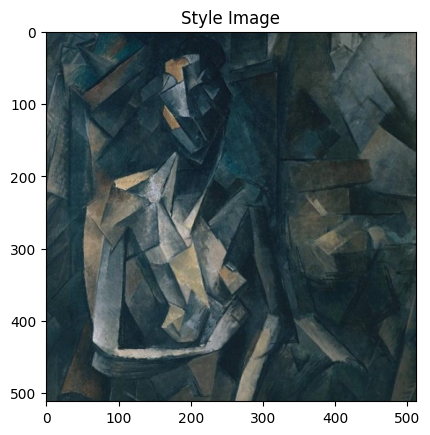

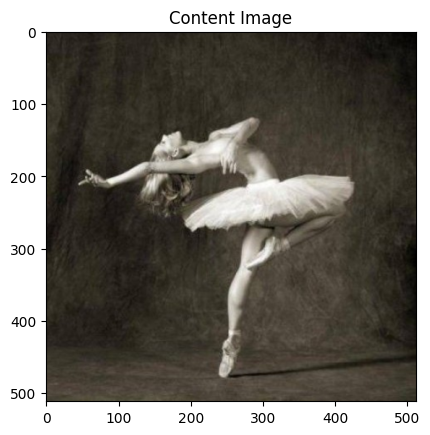

In [14]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
imshow(style_img, title="Style Image")

plt.figure()
imshow(content_img, title="Content Image")

## Content Loss

In [16]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super().__init__()
    # We "Detach" the target content from the tree used to dynamically compute the gradient:
    # this is a stated value, not a variable. Otherwise the forward method of the criterion
    # will throw an error
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

## Style Loss

In [17]:
def gram_matrix(input):
  a, b, c, d = input.size()
  # a - batch, b - amount of feature maps, c x d - shape of each feature maps
  features = input.view(a * b, c * d)
  G = torch.mm(features, features.t())
  return G.div(a * b * c * d)

In [18]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super().__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

## Importing the Model

In [19]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 73.7MB/s]


In [30]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super().__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

In [21]:
from torch._higher_order_ops.run_const_graph import run_const_graph_functional
# desired depth layers to compute style / content losses:
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

def get_style_model_and_losses(
    cnn, normalization_mean, normalization_std, style_img, content_img,
    content_layers=content_layers_default,
    style_layers=style_layers_default
):
  normalization = Normalization(normalization_mean, normalization_std)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)
  i = 0 # increment every time we see a conv
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = "conv_{}".format(i)
    elif isinstance(layer, nn.ReLU):
      name = "relu_{}".format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = "pool_{}".format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = "bn_{}".format(i)
    else:
      raise RuntimeError("Unrecognized layer: {}".format(layer.__class__.__name__))
    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  # we trim off the layers after the last content and style loss
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[: (i + 1)]
  return model, style_losses, content_losses

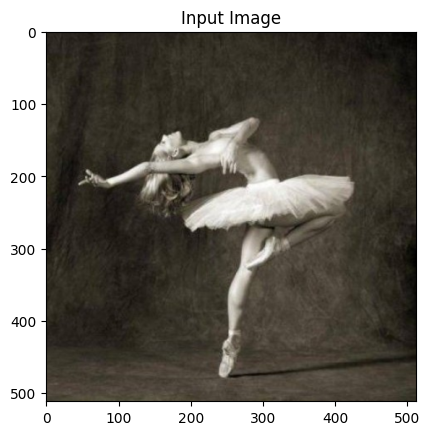

In [24]:
input_img = content_img.clone()
# If you want to use the white noise
# input_img = torch.randn(content_img.data.size())

plt.figure()
imshow(input_img, title="Input Image")

## Gradient Descent

In [25]:
def get_input_optimizer(input_img):
  # this line to show that input is a parameter that requires a gradient
  optimizer = optim.LBFGS([input_img])
  return optimizer

In [34]:
def NST(
    cnn, normalization_mean, normalization_std, content_img, style_img, input_img,
    num_step=300, style_weight=1000000, content_weight=1
):
  print("Building the style transfer model...")
  model, style_losses, content_losses = get_style_model_and_losses(
      cnn, normalization_mean, normalization_std, style_img, content_img
  )

  input_img.requires_grad_(True)
  model.eval()
  model.requires_grad_(False)
  optimizer = get_input_optimizer(input_img)

  print("Optimizing...")
  run = [0]
  while run[0] <= num_step:
    def closure():
      # correct the values of updated input image
      with torch.no_grad():
        input_img.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      style_score *= style_weight
      content_score *= content_weight
      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print("Style Loss: {:4f}, Content Loss: {:4f}".format(
            style_score.item(), content_score.item()
        ))
        print()
      return style_score + content_score
    optimizer.step(closure)
  with torch.no_grad():
    input_img.clamp_(0, 1)
  return input_img

Building the style transfer model...
Optimizing...
run [50]:
Style Loss: 4.954025, Content Loss: 4.118162

run [100]:
Style Loss: 1.136458, Content Loss: 3.023762

run [150]:
Style Loss: 0.703275, Content Loss: 2.645331

run [200]:
Style Loss: 0.479219, Content Loss: 2.487579

run [250]:
Style Loss: 0.345531, Content Loss: 2.400683

run [300]:
Style Loss: 0.264028, Content Loss: 2.346887



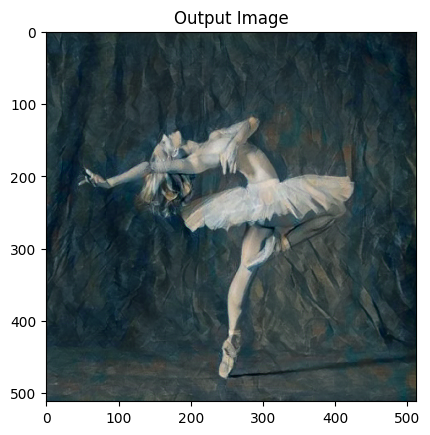

<Figure size 640x480 with 0 Axes>

In [35]:
output = NST(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    content_img, style_img, input_img
)

plt.figure()
imshow(output, title="Output Image")
plt.ioff()
plt.tight_layout()
plt.show()